## Style Transfer 

Style Transfer - это перенос стиля одного изображения на другое. Впервые такая техника получила широкое распространение благодаря программе Prisma.

Попробуем использовать встроенную модель из TensorFlow Hub для переноса стиля. Загрузим стилевое изображение и основное изображение:

In [ ]:
!wget https://soshnikov.com/images/official/shwars_fall.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/6/66/VanGogh-starry_night_ballance1.jpg
!wget https://upload.wikimedia.org/wikipedia/en/e/e6/Jean_Metzinger%2C_1915%2C_Soldat_jouant_aux_%C3%A9checs_%28Soldier_at_a_Game_of_Chess%29%2C_oil_on_canvas%2C_81.3_x_61_cm%2C_Smart_Museum_of_Art.jpg

--2023-03-18 16:39:24--  https://soshnikov.com/images/official/shwars_fall.jpg
Resolving soshnikov.com (soshnikov.com)... 185.199.108.153, 185.199.109.153
Connecting to soshnikov.com (soshnikov.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328416 (321K) [image/jpeg]
Saving to: ‘shwars_fall.jpg’

shwars_fall.jpg     100%[===================>] 320.72K  --.-KB/s    in 0.03s   

2023-03-18 16:39:24 (9.67 MB/s) - ‘shwars_fall.jpg’ saved [328416/328416]

--2023-03-18 16:39:24--  https://upload.wikimedia.org/wikipedia/commons/6/66/VanGogh-starry_night_ballance1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1933764 (1.8M) [image/jpeg]
Saving to: ‘VanGogh-starry_night_ballance1.jpg’

VanGogh-starry_nigh 100%[===================>]   1.84M  --.-KB/s    

Определим функцию `load_image` для загрузки изображения и приведения его к нужному разрешению.

In [ ]:
from PIL import Image
import numpy as np

def load_image(fn,size=(512,512)):
  img = Image.open(fn).convert('RGB').resize(size,Image.LANCZOS)
  return np.expand_dims(np.array(img),0).astype(np.float32)/255.0

content_img = load_image('shwars_fall.jpg')
style_img = load_image('VanGogh-starry_night_ballance1.jpg')
style_img1 = load_image('Jean_Metzinger,_1915,_Soldat_jouant_aux_échecs_(Soldier_at_a_Game_of_Chess),_oil_on_canvas,_81.3_x_61_cm,_Smart_Museum_of_Art.jpg')

Теперь загружаем необходимую модель из TensorFlow Hub:

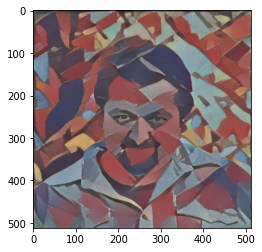

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

Для преобразования изображения запускаем следующую ячейку:

In [ ]:
stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img1))[0]
plt.imshow(stylized_image[0])

## Обрабатываем видео

С помощью этого кода можно, например, обработать видео по кадрам. Сначала загрузим видео (можно сделать это вручную через браузер)

In [ ]:
!wget http://www.soshnikov.com/permanent/data/shwars.mp4

--2023-03-18 16:46:06--  http://www.soshnikov.com/permanent/data/shwars.mp4
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 878523 (858K) [text/plain]
Saving to: ‘shwars.mp4’

shwars.mp4          100%[===================>] 857.93K   239KB/s    in 3.6s    

2023-03-18 16:46:10 (239 KB/s) - ‘shwars.mp4’ saved [878523/878523]



Разобьем видео на отдельные кадры с именами `frame000.png`, `frame001.png` и т.д.

In [ ]:
!ffmpeg -i shwars.mp4 frame%03d.png

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Теперь для каждого кадра применим перенос стиля и запишем результаты на диск с именем `oframe_000.png`, `oframe_001.png` и т.д.

In [ ]:
from tqdm import tqdm
from glob import glob

for i,fn in enumerate(tqdm(sorted(glob('frame*.png')))): 
  img = load_image(fn,size=(368,512))
  res = hub_model(tf.constant(img), tf.constant(style_img1))[0][0]
  oimg = Image.fromarray((255*res.numpy()).astype(np.uint8))
  oimg.save(f"oframe_{i:03d}.png")


100%|██████████| 76/76 [00:16<00:00,  4.55it/s]


Наконец, соберём все эти кадры вместе в файл `out.mp4`. После выполнения этой ячейки можно загрузить результат к себе на диск.

In [ ]:
!rm out.mp4
!ffmpeg -r 15 -i oframe_%03d.png -c:v libx264 -vf "fps=15,format=yuv420p" out.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e